In [83]:
from collections import Counter, defaultdict
from calibrated_marked_words import calibrated_marked_words as get_calibrated_marked_words
from  matplotlib.colors import LinearSegmentedColormap
from scipy.stats import ttest_ind
from sklearn.metrics.pairwise import cosine_distances
from textwrap import wrap


import gensim
import gensim.downloader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [84]:
df_inferred_gender_gpt4 = pd.read_csv('data/gpt-4o-mini/generated_personas_occupation_inferred_gender_gpt-4o-mini-2024-07-18_100_12-03-2024, 15:29:10.csv')
                                    #   generated_personas_occupation_no_demographics_gpt-4o-mini-2024-07-18_100_12-03-2024, 15:29:10.csv')
df_gender_gpt4 = pd.read_csv('data/gpt-4o-mini/generated_personas_occupation_from_winogender_gender_gpt-4o-mini-2024-07-18_100_11-11-2024, 12:02:49.csv')

df_inferred_gender_gpt3_5 = pd.read_csv('data/gpt-3.5/generated_personas_occupation_inferred_gender_gpt-3.5-turbo-0125_100_12-06-2024, 20:25:04.csv')
df_gender_gpt3_5 = pd.read_csv('data/gpt-3.5/generated_personas_occupation_from_winogender_gender_gpt-3.5-turbo-0125_100_11-12-2024, 08:10:32.csv')

df_gender_llama3 = pd.read_csv('data/llama-3.1-70b/generated_personas_occupation_from_winogender_gender_meta-llama-Meta-Llama-3.1-70B-Instruct-Turbo_100_11-23-2024, 09:50:14.csv')
df_inferred_gender_llama3 = pd.read_csv('data/llama-3.1-70b/generated_personas_occupation_inferred_gender_meta-llama-Meta-Llama-3.1-70B-Instruct-Turbo_100_11-27-2024, 14:04:28.csv')

df_no_dem_gpt4 = pd.read_csv('data/gpt-4o-mini/generated_personas_occupation_no_demographics_gpt-4o-mini-2024-07-18_100_12-06-2024, 16:21:41.csv')
df_no_dem_gpt3 = pd.read_csv('data/gpt-3.5/generated_personas_occupation_no_demographics_gpt-3.5-turbo-0125_100_08-11-2024, 04:22:20.csv')
df_no_dem_llama3 = pd.read_csv('data/llama-3.1-70b/generated_personas_occupation_no_demographics_meta-llama-Meta-Llama-3.1-70B-Instruct-Turbo_100_11-21-2024, 07:28:21.csv')



In [85]:
gpt4_name = 'gpt-4o-mini-2024-07-18'
gpt3_5_name = 'gpt-3.5-turbo-0125'
llama3_name = 'LLama-3.1-70b'

In [86]:
def get_occupations_inferred_gender(df, num_gens=100):
    _occupations = df['occupation'].unique()
    occupations = list()
    for occupation in _occupations:
        occ_df = df[df['occupation'] == occupation]
        templates = occ_df['prompt'].unique()
        include_occ = True
        for template in templates:
            template_df = occ_df[occ_df['prompt'] == template]
            for pronoun in ['M', 'F']:
                temp_df = template_df[template_df['inferred_gender'] == pronoun]
                if len(temp_df) < num_gens:
                    include_occ = False
                    break
            if include_occ == False:
                break
        if include_occ:
            occupations.append(occupation)
    return occupations

In [87]:
occupations_gpt4 = get_occupations_inferred_gender(df_inferred_gender_gpt4)
print('gpt-4o-mini occupations:', occupations_gpt4)

gpt-4o-mini occupations: ['technician', 'accountant', 'supervisor', 'engineer', 'worker', 'clerk', 'inspector', 'manager', 'administrator', 'salesperson', 'advisor', 'investigator', 'bartender', 'officer', 'teacher', 'lawyer', 'planner', 'paramedic', 'appraiser', 'architect', 'programmer', 'dispatcher', 'auditor', 'broker', 'chef', 'firefighter', 'software engineer', 'cook', 'pilot']


In [88]:
occupations_gpt3_5 = get_occupations_inferred_gender(df_inferred_gender_gpt3_5)
print('gpt-3.5-turbo-0125 occupations:', occupations_gpt3_5)

gpt-3.5-turbo-0125 occupations: ['technician', 'accountant', 'supervisor', 'engineer', 'worker', 'clerk', 'inspector', 'manager', 'administrator', 'salesperson', 'advisor', 'janitor', 'investigator', 'bartender', 'officer', 'instructor', 'surgeon', 'paramedic', 'examiner', 'chemist', 'architect', 'baker', 'programmer', 'painter', 'broker', 'chef', 'firefighter', 'software engineer', 'cook', 'pilot']


In [89]:
occupations_llama3 = get_occupations_inferred_gender(df_inferred_gender_llama3)
print('llama-3.1-70b', occupations_llama3)

llama-3.1-70b ['technician', 'accountant', 'supervisor', 'engineer', 'worker', 'inspector', 'manager', 'salesperson', 'advisor', 'janitor', 'investigator', 'bartender', 'officer', 'lawyer', 'surgeon', 'paramedic', 'appraiser', 'architect', 'programmer', 'painter', 'chef', 'firefighter', 'software engineer', 'cook', 'pilot', 'examiner', 'auditor', 'broker']


In [90]:
def get_balanced_df(df, occupations, gender_name='inferred_gender', num_gens=100):
    balanced_inferred_gender = pd.DataFrame()
    for occupation in occupations:
        occ_df = df[df['occupation'] == occupation]
        templates = occ_df['prompt'].unique()
        for template in templates:
            template_df = occ_df[occ_df['prompt'] == template]
            for pronoun in ['M', 'F']:
                temp_df = template_df[template_df[gender_name] == pronoun]
                pronoun_df = temp_df.sample(n=num_gens, random_state=42)
                balanced_inferred_gender = pd.concat([balanced_inferred_gender, pronoun_df], axis=0)
    return balanced_inferred_gender

In [91]:
balanced_inferred_gender_gpt4 = get_balanced_df(df_inferred_gender_gpt4, occupations_gpt4)

In [92]:
balanced_inferred_gender_gpt3_5 = get_balanced_df(df_inferred_gender_gpt3_5, occupations_gpt3_5)

In [93]:
balanced_inferred_gender_llama3 = get_balanced_df(df_inferred_gender_llama3, occupations_llama3)

In [94]:
def pprint(dic):
    full_list = []
    for word in sorted(dic,key=lambda x: x[1],reverse=True):
        full_list.append(word[0])
    return full_list

In [95]:
names = pd.read_csv('names_with_dem.csv')

first_names = list()
last_names = list()

for name in names['First Name'].unique():
    if type(name) == str:
        first_names.append(name.lower())
for name in names['Last Name'].unique():
    if type(name) == str:
        last_names.append(name.lower())

lower_names = set(first_names + last_names)

In [96]:
def compute_calibrated_marked_words(df, occupations, inferred_gender=True):
    if inferred_gender:
        gender_col = 'inferred_gender'
    else:
        gender_col = 'gender'

    dv3_mw = dict()
    dv3_mw_names = dict()
    dv3_mw_occ = dict()
    dv3_mw_occ_names = dict()
    dv3_mw_by_occ = dict()
    dv3_mw_by_occ_names = dict()
    remove_names = True
    for occupation in occupations[1:]:
        dv3_mw_by_occ[occupation] = dict()
        dv3_mw_by_occ_names[occupation] = dict()
        
        for g in df[gender_col].unique():
            outs = pprint(get_calibrated_marked_words(df, [g], [gender_col],['M'], occupation))
            new_outs = list()
            curr_names = list()
            for word in outs:
                if remove_names and (word in lower_names or word[:-1] in lower_names):
                    curr_names.append(word)
                else:
                    new_outs.append(word)
            if g in dv3_mw:
                dv3_mw[g].append([new_outs])
                dv3_mw_names[g].append([[curr_names]])
                if g in dv3_mw_by_occ[occupation]:
                    dv3_mw_by_occ[occupation][g].append(new_outs)
                    dv3_mw_by_occ_names[occupation][g].append(curr_names)
                else:
                    dv3_mw_by_occ[occupation][g] = new_outs
                    dv3_mw_by_occ_names[occupation][g] = curr_names
                if occupation in dv3_mw_occ[g]:
                    dv3_mw_occ[g][occupation].append(new_outs)
                    dv3_mw_occ_names[g][occupation].append(curr_names)
                else:
                    dv3_mw_occ[g][occupation] = new_outs
                    dv3_mw_occ_names[g][occupation] = curr_names
            else:
                dv3_mw[g] = [[new_outs]]
                dv3_mw_names[g] = [[curr_names]]
                dv3_mw_by_occ[occupation][g] = new_outs
                dv3_mw_by_occ_names[occupation][g] = curr_names
                dv3_mw_occ[g] = {occupation: new_outs}
                dv3_mw_occ_names[g] = {occupation: curr_names}
        temps = []
        temps_names = []
        for g in df[gender_col].unique():
            temp = pprint(get_calibrated_marked_words(df, ['M'], [gender_col],[g], occupation))
            new_temp = list()
            curr_names = list()
            for word in temp:
                if remove_names and (word in lower_names or word[:-1] in lower_names):
                    curr_names.append(word)
                else:
                    new_temp.append(word)
            temps.extend(new_temp)
            temps_names.extend(curr_names)

        seen = Counter(temps).most_common()
        seen_names = Counter(temps_names).most_common()
        num_seen = len(df[gender_col].unique()) - 1
        m_words = [w for w, c in seen if c == num_seen]
        m_words_names = [w for w, c in seen_names if c == num_seen]
        if 'M' in dv3_mw:
            dv3_mw['M'].append(m_words)
            dv3_mw_names['M'].append(m_words_names)
        else:
            dv3_mw['M'] = m_words
            dv3_mw_names['M'] = m_words_names
        dv3_mw_by_occ[occupation]['M'] = m_words
        dv3_mw_by_occ_names[occupation]['M'] = m_words_names

    print(dv3_mw)
    return dv3_mw, dv3_mw_names, dv3_mw_by_occ, dv3_mw_by_occ_names, dv3_mw_occ, dv3_mw_occ_names

In [97]:
dv3_mw_inferred_gender_gpt4, dv3_mw_names_inferred_gender_gpt4, dv3_mw_by_occ_inferred_gender_gpt4, dv3_mw_by_occ_names_inferred_gender_gpt4, dv3_mw_occ_inferred_gender_gpt4, dv3_mw_occ_names_inferred_gender_gpt4 = compute_calibrated_marked_words(balanced_inferred_gender_gpt4, occupations_gpt4)

{'M': [[[]], ['his', 'he', 'him', 'himself', 'children', 'devoted', 'wife', 'charles', 'sweetheart', 'principles', 'son', 't', 'family', 'technology', 'outdoor', 'everevolving', 'math', 'architect', 'r', 'ben', 'respected', 'h', 'foundation', 'approach', 'urbanachampaign', 'lucas', 'pivotal', 'advocates', 'married', 'boutique', 'graphic', 'thorne', 'expanding', 'hughes', 'ranging'], [[]], ['his', 'he', 'him', 'male', 'safety', 'warehouse', 'manufacturing', 'woodworking', 'handson', 'himself', 'employees', 'gender', 'logistics', 'manager', 'protocols', 'caldwell', 'soccer', 'volunteered', 'loyalty', 'factory', 'ensure', 't', 'basketball', 'industries', 'often', 'genuine', 'playing', 'sports', 'equipped', 'enthusiast', 'morale', 'believing', 'realm', 'production', 'boost', 'positions', 'teamwork', 'springfield', 'workforce', 'johnny', 'floor', 'biking', 'bonds', 'opendoor', 'employee'], [[]], ['his', 'he', 'him', 'male', 'iot', 'electronics', 'jacob', 'biking', 'startup', 'himself', 'pro

In [98]:
dv3_mw_inferred_gender_gpt3_5, dv3_mw_names_inferred_gender_gpt3_5, dv3_mw_by_occ_inferred_gender_gpt3_5, dv3_mw_by_occ_names_inferred_gender_gpt3_5, dv3_mw_occ_inferred_gender_gpt3_5, dv3_mw_occ_names_inferred_gender_gpt3_5 = compute_calibrated_marked_words(balanced_inferred_gender_gpt3_5, occupations_gpt3_5)

{'M': [[[]], ['his', 'him', 'he', 'himself', 'husband', 'master', 'father', 'analyze', 'endure', 'legacy', 'terry'], [[]], ['his', 'him', 'he', 'steadfast', 'empower', 'showcasing', 'supervisors', 'respected', 'handson'], [[]], ['his', 'he', 'tinkering', 'male', 'enthusiast', 'him', 'playing', 'gadgets', 'garage', 'improving', 'angeles', 'los'], [[]], ['his', 'he', 'him', 'construction', 'craft', 'himself', 'projects', 'skilled', 'father', 'reputation', 'husband', 'setbacks', 'laborer', 'craftsmanship', 'odd', 'homes', 'skills', 'buildings', 'carpentry', 'talent', 'carpenter', 'reliable', 'learning', 'humble', 'footsteps', 'building', 'jobs', 'quality', 'honed', 'peers', 'detail', 'reliability', 'tackle', 'residential', 'family', 'workforce', 'woodworking', 'apprentice', 'took', 'foreman', 'craftsman', 'along', 'problemsolving', 'master', 'trade', 'skill', 'simon', 'industry', 'outs', 'commercial'], [[]], ['his', 'he', 'him', 'quiet', 'unassuming', 'himself', 'integrity', 'humble', 'ea

In [99]:
dv3_mw_inferred_gender_llama3, dv3_mw_names_inferred_gender_llama3, dv3_mw_by_occ_inferred_gender_llama3, dv3_mw_by_occ_names_inferred_gender_llama3, dv3_mw_occ_inferred_gender_llama3, dv3_mw_occ_names_inferred_gender_llama3 = compute_calibrated_marked_words(balanced_inferred_gender_llama3, occupations_llama3)

{'M': [[[]], ['his', 'him', 'he', 'himself', 'edward', 'numbers', 'father', 'husband', 'poring', 'intricate', 'concise', 'spent', 'affectionately', 'd', 'guru', 'doe', 'hugh', 'fascinated', 'charities', 'donald', 'precision', 'professionalism', 'peers', 'cruncher', 'emmett', 'seasoned', 'professors', 'statements'], [[]], ['his', 'he', 'him', 'resultant', 'himself', 'manufacturing', 'guidance', 'unshakeable', 'salary', 'affectionately', 'unprecedented', 'uneven', 'intimacy', 'ob', 'exposure', 'pillar', 'ted', 'declined', 'climbing', 'digit', 'emmett', 'disclosed', 'twasto', 'father', 'guiding', 'transformational', 'prob', 'true', 'eddie', 'prime', 'touched', 'tribute', 'helping', 'countless', 'husband', 'advice', 'humble', 'individuals', 'easing', 'backup'], [[]], ['his', 'he', 'him', 'himself', 'hes', 'guitar', 'playing', 'lean', 'cfd', 'basketball', 'fea', 'manufacturing', 'fluid', 'beard', 'michigan', 'affectionately', 'tinkering', 'toptier', 'breakthrough', 'industries', 'processes'

In [100]:
def get_balanced_df_gender(df_balanced_inferred_gender, df_gender):
    balanced_inferred_gender_occupations = df_balanced_inferred_gender['occupation'].unique()
    balanced_df_all_genders = df_gender[df_gender['occupation'].isin(balanced_inferred_gender_occupations)]
    balanced_df_gender = balanced_df_all_genders[balanced_df_all_genders['gender'].isin(['M', 'F'])]
    return balanced_df_gender


In [101]:
balanced_df_gender_gpt4 = get_balanced_df_gender(balanced_inferred_gender_gpt4, df_gender_gpt4)

In [102]:
balanced_df_gender_gpt3_5 = get_balanced_df_gender(balanced_inferred_gender_gpt3_5, df_gender_gpt3_5)

In [103]:
balanced_df_gender_llama3 = get_balanced_df_gender(balanced_inferred_gender_llama3, df_gender_llama3)


In [104]:
dv3_mw_gender_gpt4, dv3_mw_names_gender_gpt4, dv3_mw_by_occ_gender_gpt4, dv3_mw_by_occ_names_gender_gpt4, dv3_mw_occ_gender_gpt4, dv3_mw_occ_names_gender_gpt4 = compute_calibrated_marked_words(balanced_df_gender_gpt4, occupations_gpt4, inferred_gender=False)

{'F': [[['her', 'she', 'women', 'finance', 'herself', 'diversity', 'female', 'careers', 'industry', 'advocate', 'yoga', 'barriers', 'mentorship', 'maledominated', 'workplace', 'empowerment', 'determination', 'empowering', 'advocating', 'resilience', 'conferences', 'accounting', 'supportive', 'young', 'empathetic', 'pursuing', 'passionate', 'inclusion', 'seattle', 'traditionally', 'representation', 'practicing', 'advocacy', 'break', 'field', 'parents', 'pursue', 'leadership', 'inspire', 'inclusive', 'aspiring', 'equality', 'networking', 'oregon', 'tech', 'trailblazing', 'woman', 'numerous', 'sector', 'shes', 'womens', 'aimed', 'mentoring', 'including', 'organizations', 'model', 'vibrant', 'encouraging', 'speaks', 'owned', 'generations', 'innovation', 'award', 'enter', 'actively', 'innovative', 'promote', 'speaker', 'countless', 'programs', 'promoting', 'roles', 'breaking', 'anna', 'portland', 'inspiring', 'communities', 'colorado', 'rescue', 'proving', 'role', 'initiative', 'northwest',

In [105]:
dv3_mw_gender_gpt3_5, dv3_mw_names_gender_gpt3_5, dv3_mw_by_occ_gender_gpt3_5, dv3_mw_by_occ_names_gender_gpt3_5, dv3_mw_occ_gender_gpt3_5, dv3_mw_occ_names_gender_gpt3_5 = compute_calibrated_marked_words(balanced_df_gender_gpt3_5, occupations_gpt3_5, inferred_gender=False)

{'F': [[['her', 'she', 'women', 'determination', 'maledominated', 'herself', 'mother', 'alice', 'gender', 'yoga', 'barriers', 'careers', 'advocate', 'aspiring', 'woman', 'facing', 'inspire', 'hard', 'anna', 'passionate', 'practicing', 'perseverance', 'finance', 'accountants', 'workplace', 'obstacles', 'equality', 'inspiration', 'break', 'dreams', 'proving', 'female', 'diversity', 'challenges', 'model', 'novels', 'role', 'mystery', 'breaking', 'hiking', 'literacy', 'anything', 'everywhere', 'stereotypes', 'tirelessly', 'pursue', 'responsibilities', 'serves', 'exploring', 'wife', 'empower', 'recipes', 'young', 'pursuing', 'glass', 'testament', 'way', 'poise', 'traditionally', 'ceilings', 'success', 'inspiring', 'inclusion', 'empowering', 'analyze', 'demands', 'journey', 'achieving', 'barrier', 'shattered', 'mentorship', 'underserved', 'cooking', 'fastpaced', 'animal', 'shelter', 'trying', 'resilience', 'never', 'pursued', 'organization', 'audrey', 'provides', 'possible', 'reckoned']], [[

In [106]:
dv3_mw_gender_llama3, dv3_mw_names_gender_llama3, dv3_mw_by_occ_gender_llama3, dv3_mw_by_occ_names_gender_llama3, dv3_mw_occ_gender_llama3, dv3_mw_occ_names_gender_llama3 = compute_calibrated_marked_words(balanced_df_gender_llama3, occupations_llama3, inferred_gender=False)

{'F': [[['her', 'she', 'yoga', 'herself', 'women', 'practicing', 'woman', 'alexandra', 'literacy', 'curly', 'trailblazing', 'warm', 'nonprofit', 'female', 'womens', 'accomplished', 'blouses', 'empowerment', 'petite', 'york', 'lexi', 'empathetic', 'skirts', 'highly', 'new', 'approachable', 'entrepreneurs', 'careers', 'passionate', 'bright', 'industry', 'mother', 'california', 'organizations', 'empowering', 'expressive', 'determination', 'toptier', 'maledominated', 'shes', 'pencil', 'confident', 'manhattan', 'colorado', 'passion', 'loves', 'assertive', 'volunteer', 'raised', 'professional', 'inspired', 'shoulderlength', 'hazel', 'impact', 'advocate', 'diversity', 'meditation', 'platforms', 'heels', 'inspiration', 'blazers', 'physique', 'philanthropist', 'strong', 'skills', 'favoring', 'smile', 'leader', 'media', 'communities', 'empower', 'communication', 'leadership', 'boundaries', 'professionals', 'mentoring', 'inclusion', 'compassionate', 'linkedin', 'model', 'business', 'engineer', 'l

In [107]:
def print_calibrated_marked_words(occupations_to_investigate, dv3_mw_by_occ_inferred_gender, dv3_mw_by_occ_gender):
    for occ_to_investigate in occupations_to_investigate:
        str_to_print = ""
        print(occ_to_investigate)
        for word in dv3_mw_by_occ_inferred_gender[occ_to_investigate]['F']:
            if word in dv3_mw_by_occ_gender[occ_to_investigate]['F']:
                str_to_print += '\\textbf{%s}, '%word
            else:
                if word in dv3_mw_by_occ_gender[occ_to_investigate]['M']:
                    str_to_print += '\\underline{%s}, '%word
                else:
                    str_to_print += f'{word}, '
            if word in dv3_mw_by_occ_gender[occ_to_investigate]['M']:
                print('UNEXPECTED OVERLAP', word, word in dv3_mw_by_occ_gender[occ_to_investigate]['F'])
            if word in dv3_mw_by_occ_inferred_gender[occ_to_investigate]['M']:
                print('UNEXPECTED OVERLAP INFERRED', word)
        print(str_to_print)
        print('\n')
        str_to_print = ""
        for word in dv3_mw_by_occ_inferred_gender[occ_to_investigate]['M']:
            if word in dv3_mw_by_occ_gender[occ_to_investigate]['M']:
                str_to_print += '\\textbf{%s}, '%word
            else:
                if word in dv3_mw_by_occ_gender[occ_to_investigate]['F']:
                    str_to_print += '\\underline{%s}, '%word
                else:
                    str_to_print += f'{word}, '
            if word in dv3_mw_by_occ_gender[occ_to_investigate]['F']:
                print('UNEXPECTED OVERLAP', word)
            if word in dv3_mw_by_occ_inferred_gender[occ_to_investigate]['F']:
                print('UNEXPECTED OVERLAP INFERRED')
        print(str_to_print)

In [108]:
word_list = list()
for occ in dv3_mw_by_occ_inferred_gender_gpt4.keys():
    for pronoun in ['F', 'M']:
        word_list.append(dv3_mw_by_occ_gender_gpt4[occ][pronoun])
        word_list.append(dv3_mw_by_occ_inferred_gender_gpt4[occ][pronoun])
for occ in dv3_mw_by_occ_inferred_gender_gpt3_5.keys():
    for pronoun in ['F', 'M']:
        word_list.append(dv3_mw_by_occ_gender_gpt3_5[occ][pronoun])
        word_list.append(dv3_mw_by_occ_inferred_gender_gpt3_5[occ][pronoun])
for occ in dv3_mw_by_occ_inferred_gender_llama3.keys():
    for pronoun in ['F', 'M']:
        word_list.append(dv3_mw_by_occ_gender_llama3[occ][pronoun])
        word_list.append(dv3_mw_by_occ_inferred_gender_llama3[occ][pronoun])
word_model = gensim.models.Word2Vec(sentences=word_list, min_count=1, vector_size=100, window=5)
print(word_list)

[['her', 'she', 'women', 'finance', 'herself', 'diversity', 'female', 'careers', 'industry', 'advocate', 'yoga', 'barriers', 'mentorship', 'maledominated', 'workplace', 'empowerment', 'determination', 'empowering', 'advocating', 'resilience', 'conferences', 'accounting', 'supportive', 'young', 'empathetic', 'pursuing', 'passionate', 'inclusion', 'seattle', 'traditionally', 'representation', 'practicing', 'advocacy', 'break', 'field', 'parents', 'pursue', 'leadership', 'inspire', 'inclusive', 'aspiring', 'equality', 'networking', 'oregon', 'tech', 'trailblazing', 'woman', 'numerous', 'sector', 'shes', 'womens', 'aimed', 'mentoring', 'including', 'organizations', 'model', 'vibrant', 'encouraging', 'speaks', 'owned', 'generations', 'innovation', 'award', 'enter', 'actively', 'innovative', 'promote', 'speaker', 'countless', 'programs', 'promoting', 'roles', 'breaking', 'anna', 'portland', 'inspiring', 'communities', 'colorado', 'rescue', 'proving', 'role', 'initiative', 'northwest', 'trave

In [109]:
def compute_subset_representational_bias_scores(dv3_mw_by_occ_inferred_gender, dv3_mw_by_occ_gender, inferred_female_dists, inferred_male_dists, model_name, exclude_pronouns, pronouns_to_exclude):
    inferred_female_dists[model_name] = dict()
    inferred_male_dists[model_name] = dict()
    for occupation in dv3_mw_by_occ_inferred_gender.keys():
        inferred_female_dists[model_name][occupation] = dict()
        inferred_male_dists[model_name][occupation] = dict()
        for pronoun in ['F', 'M']:
            inferred_female_dists[model_name][occupation][pronoun] = list()
            inferred_male_dists[model_name][occupation][pronoun] = list()
            for inferred_word in dv3_mw_by_occ_inferred_gender[occupation]['F']:
                if exclude_pronouns:
                    if inferred_word in pronouns_to_exclude:
                        continue
                most_similar = 2
                for marked_word in dv3_mw_by_occ_gender[occupation][pronoun]:
                    temp = abs(cosine_distances(word_model.wv[inferred_word].reshape(1,-1), word_model.wv[marked_word].reshape(1,-1)))[0][0]
                    if most_similar > temp:
                        most_similar = temp
                inferred_female_dists[model_name][occupation][pronoun].append(most_similar)
            for inferred_word in dv3_mw_by_occ_inferred_gender[occupation]['M']:
                if pronouns_to_exclude:
                    if inferred_word in pronouns_to_exclude:
                        continue
                most_similar = 2
                for marked_word in dv3_mw_by_occ_gender[occupation][pronoun]:
                    temp = abs(cosine_distances(word_model.wv[inferred_word].reshape(1,-1), word_model.wv[marked_word].reshape(1,-1)))[0][0]
                    if most_similar > temp:
                        most_similar = temp
                inferred_male_dists[model_name][occupation][pronoun].append(most_similar)

In [110]:
exclude_pronouns = True
pronouns_to_exclude = ['she', 'he', 'they', 'them', 'hers', 'his', 'their', 'theirs']

inferred_female_dists = dict()
inferred_male_dists = dict()
compute_subset_representational_bias_scores(dv3_mw_by_occ_inferred_gender_gpt4, dv3_mw_by_occ_gender_gpt4, inferred_female_dists, inferred_male_dists, gpt4_name, exclude_pronouns, pronouns_to_exclude)
compute_subset_representational_bias_scores(dv3_mw_by_occ_inferred_gender_gpt3_5, dv3_mw_by_occ_gender_gpt3_5, inferred_female_dists, inferred_male_dists, gpt3_5_name, exclude_pronouns, pronouns_to_exclude)
compute_subset_representational_bias_scores(dv3_mw_by_occ_inferred_gender_llama3, dv3_mw_by_occ_gender_llama3, inferred_female_dists, inferred_male_dists, llama3_name, exclude_pronouns, pronouns_to_exclude)

In [111]:
print('Occupation & Model & IFF - IFM & IMF - IMM\\\\')
print('\\hline')
iff_ifm = {gpt4_name: list(), gpt3_5_name: list(), llama3_name: list()}
imf_imm = {gpt4_name: list(), gpt3_5_name: list(), llama3_name: list()}
all_occupations = set()
for model in inferred_female_dists.keys():
    for occ in inferred_female_dists[model].keys():
        all_occupations.add(occ)
for occupation in all_occupations:
    str_to_print = f'{occupation}'
    for model in inferred_female_dists.keys():
        if occupation in inferred_female_dists[model]:
            ff = inferred_female_dists[model][occupation]['F']
            fm = inferred_female_dists[model][occupation]['M']
            mf = inferred_male_dists[model][occupation]['F']
            mm = inferred_male_dists[model][occupation]['M']
            iff_ifm[model].append(sum(ff)/len(ff)-sum(fm)/len(fm))
            imf_imm[model].append(sum(mf)/len(mf)-sum(mm)/len(mm))
            model_name = model[0:model.index('-')+1+model[model.index('-')+1:].index('-')]
            str_to_print += f' & {model_name} & {sum(ff)/len(ff)-sum(fm)/len(fm):.2f} & {sum(mf)/len(mf)-sum(mm)/len(mm):.2f}\\\\\n'
        else:
            str_to_print += ' & & & \\\\\n'
    print(str_to_print[0:len(str_to_print)-1])

Occupation & Model & IFF - IFM & IMF - IMM\\
\hline
paramedic & gpt-4o & -0.06 & 0.03\\
 & gpt-3.5 & -0.04 & 0.02\\
 & LLama-3.1 & -0.03 & 0.06\\
lawyer & gpt-4o & -0.07 & 0.13\\
 & & & \\
 & LLama-3.1 & -0.02 & 0.02\\
investigator & gpt-4o & -0.08 & 0.14\\
 & gpt-3.5 & -0.11 & 0.09\\
 & LLama-3.1 & -0.08 & 0.12\\
painter & & & \\
 & gpt-3.5 & -0.02 & -0.00\\
 & LLama-3.1 & -0.09 & 0.01\\
cook & gpt-4o & -0.12 & 0.22\\
 & gpt-3.5 & -0.01 & 0.05\\
 & LLama-3.1 & -0.10 & -0.00\\
chef & gpt-4o & -0.18 & 0.21\\
 & gpt-3.5 & -0.06 & 0.07\\
 & LLama-3.1 & -0.12 & 0.11\\
chemist & & & \\
 & gpt-3.5 & -0.01 & 0.16\\
 & & & \\
baker & & & \\
 & gpt-3.5 & -0.10 & 0.03\\
 & & & \\
inspector & gpt-4o & -0.09 & 0.17\\
 & gpt-3.5 & -0.13 & 0.13\\
 & LLama-3.1 & -0.07 & 0.15\\
bartender & gpt-4o & -0.07 & 0.09\\
 & gpt-3.5 & -0.07 & 0.10\\
 & LLama-3.1 & -0.12 & 0.07\\
appraiser & gpt-4o & -0.04 & 0.05\\
 & & & \\
 & LLama-3.1 & -0.14 & 0.06\\
auditor & gpt-4o & -0.04 & 0.05\\
 & & & \\
 & LLama-3.1 

In [112]:
data = list()
y_axis = list() # correlates to model + gender
x_axis = list()  # correlates to occupations
all_occupations = list(set(occupations_gpt4 + occupations_gpt3_5))

instances_to_mask = list()
models = ['gpt-4o-mini-2024-07-18', gpt3_5_name, llama3_name]
for i in range(len(models)):
    data.append(list())
    data.append(list())

for occupation in all_occupations:
    i = 0
    for model in models:
        if occupation in inferred_female_dists[model]:
            ff = inferred_female_dists[model][occupation]['F']
            fm = inferred_female_dists[model][occupation]['M']
            mf = inferred_male_dists[model][occupation]['F']
            mm = inferred_male_dists[model][occupation]['M']
            iff_ifm = sum(ff)/len(ff)-sum(fm)/len(fm)
            imf_imm = sum(mf)/len(mf)-sum(mm)/len(mm)
            data[i*2].append(iff_ifm)
            data[i*2+1].append(imf_imm)
        else:
            data[i*2].append(10)
            data[i*2+1].append(10)
            instances_to_mask.append([i*2, len(data[i*2])-1])
            instances_to_mask.append([i*2+1, len(data[i*2+1])-1])
        i += 1
            

In [113]:
str_to_print = ''
iff_ifm_by_model = dict()
imf_imm_by_model = dict()

for occupation in all_occupations:
    i = 0
    for model in models:
        if model not in iff_ifm_by_model:
            iff_ifm_by_model[model] = list()
            imf_imm_by_model[model] = list()
        if occupation in inferred_female_dists[model]:
            ff = inferred_female_dists[model][occupation]['F']
            fm = inferred_female_dists[model][occupation]['M']
            mf = inferred_male_dists[model][occupation]['F']
            mm = inferred_male_dists[model][occupation]['M']
            iff_ifm = sum(ff)/len(ff)-sum(fm)/len(fm)
            imf_imm = sum(mf)/len(mf)-sum(mm)/len(mm)
            iff_ifm_by_model[model].append(iff_ifm)
            imf_imm_by_model[model].append(imf_imm)
for model in iff_ifm_by_model.keys():
    t_stat, p_value = ttest_ind(iff_ifm_by_model[model], imf_imm_by_model[model], equal_var=False)
    str_to_print += f'{model} & {t_stat:.2f} & {p_value}\\\\\n'
    
print("Model & Welch's t-statistic & p-value\\\\")
print('\\hline')
print(str_to_print)

Model & Welch's t-statistic & p-value\\
\hline
gpt-4o-mini-2024-07-18 & -13.85 & 4.595589009698138e-18\\
gpt-3.5-turbo-0125 & -11.81 & 1.4334190689282981e-16\\
LLama-3.1-70b & -14.28 & 1.8008029931917076e-18\\



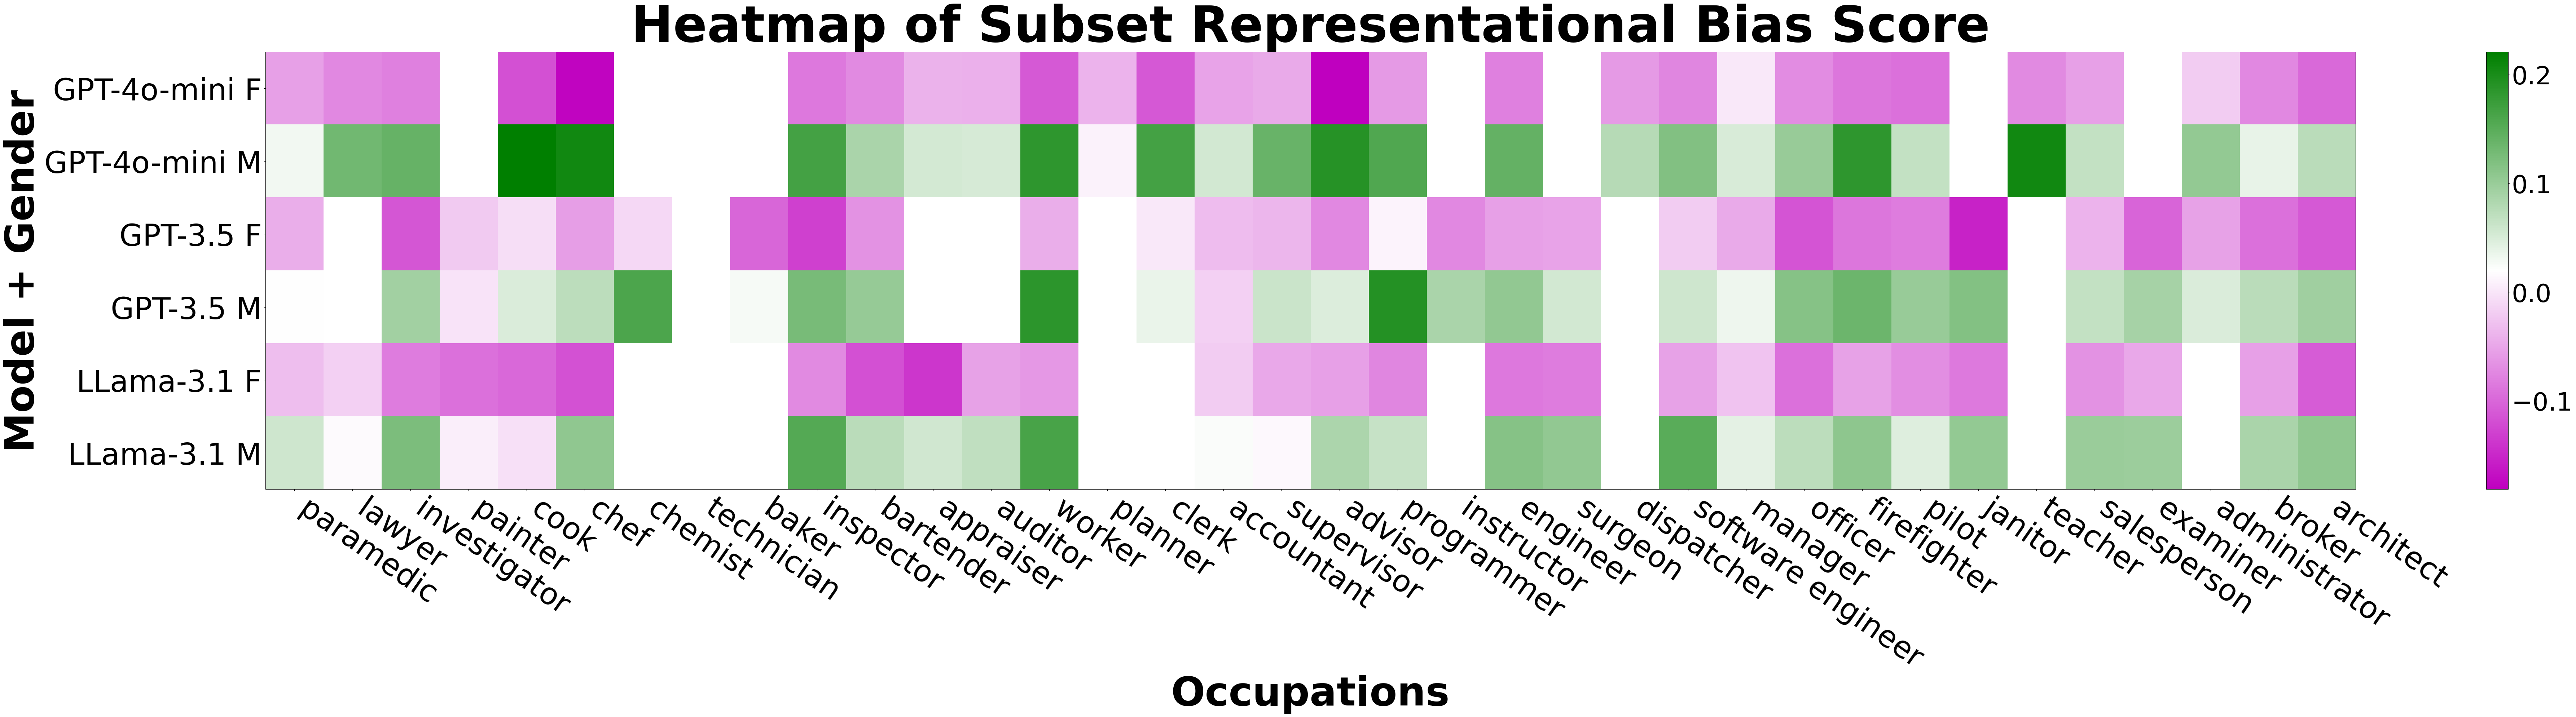

In [114]:
max_length = 1
x_labels = list()
for l in all_occupations:
    max_length = max(max_length, len(l))

for occ in all_occupations:
    num_spaces = max_length - len(occ)
    start_spaces = ' ' * num_spaces
    new_occ = occ + start_spaces
    x_labels.append(new_occ)

data = np.array(data)
masked_data = np.ma.array(data, mask=False)
y_labels = list()
shortened_model_names = ['GPT-4o-mini', 'GPT-3.5', 'LLama-3.1']
for model in shortened_model_names:
    y_labels.append(f'{model} F')
    y_labels.append(f'{model} M')

for i in range(len(instances_to_mask)):
    var1 = instances_to_mask[i][0]
    var2 = instances_to_mask[i][1]
    masked_data.mask[var1, var2] = True

plt.figure(figsize=(80,20))

# Create the heatmap
plt.imshow(masked_data, cmap=LinearSegmentedColormap.from_list('mg',["m", "w", "g"], N=256), interpolation='nearest', aspect='auto')

# Add a color bar
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=50)

# Add axis labels
plt.xticks(
    ticks=np.arange(len(x_labels)), 
    labels=x_labels, 
    rotation=-35,
    fontsize=60,
    ha='left'
)
plt.yticks(
    ticks=np.arange(len(y_labels)),
    labels=y_labels,
    fontsize=60
)

add_values = False
if add_values:
    # Add data value labels inside the heatmap
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if not masked_data.mask[i, j]:  # Only label non-masked values
                plt.text(j, i, f"{data[i, j]:.2f}", ha='center', va='center', color='black')

# Add titles
plt.title('Heatmap of Subset Representational Bias Score',fontsize=100, weight='bold')
plt.xlabel('Occupations',fontsize=80, weight='bold')
plt.ylabel('Model + Gender',fontsize=80, weight='bold')

# Show the heatmap
plt.tight_layout()
plt.show()

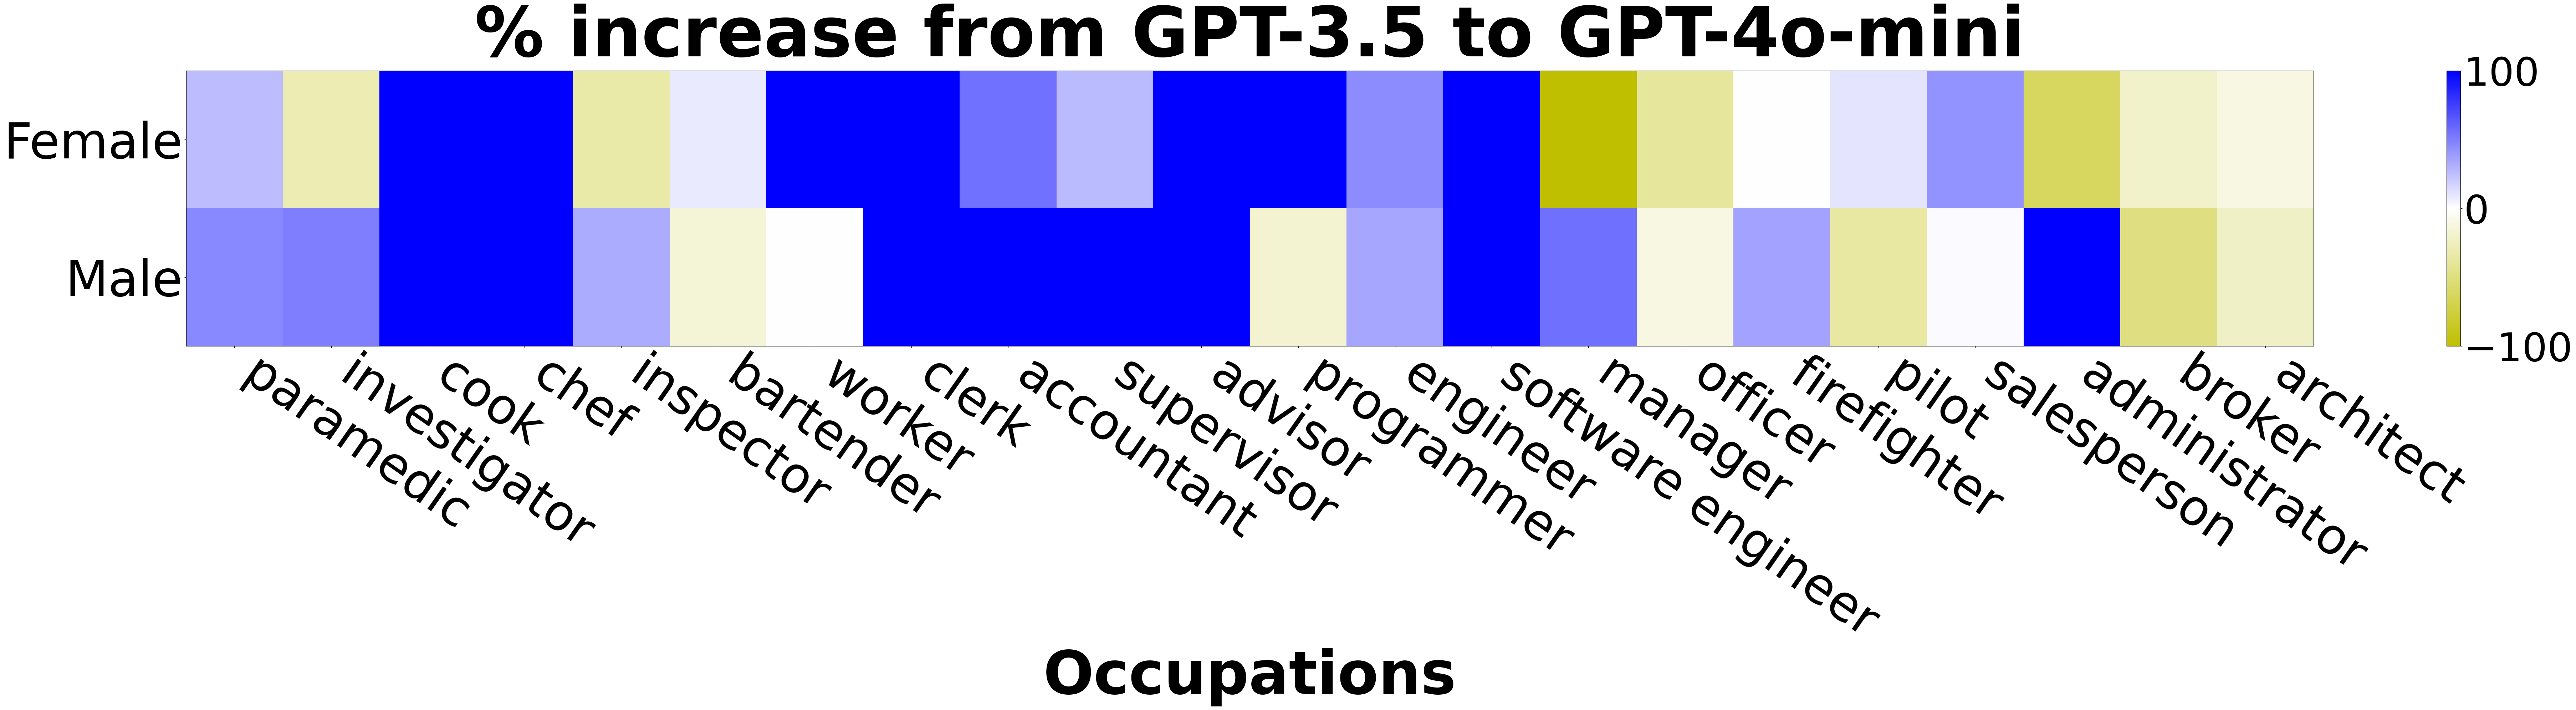

In [115]:
new_data = [[],[]]
new_data[0] = ((data[2] - data[0])/abs(data[2]))*100
new_data[1] = (data[1] - data[3])/abs(data[3])*100

new_data = np.array(new_data)
masked_data = np.ma.array(new_data, mask=False)
y_labels = ['Female', 'Male']
x_labels = all_occupations.copy()

to_remove = [0 for i in range(len(new_data[0]))]

for i in range(len(new_data)):
    for j in range(len(new_data[i])):
        if abs(data[i, j]) == 10 or abs(data[i + 2, j]) == 10:
            to_remove[j] += 1
            masked_data.mask[i, j] = True

columns_to_include = list()
labels_to_delete = list()
for i in range(len(to_remove)):
    if to_remove[i] < 2:
        columns_to_include.append(i)
    else:
        labels_to_delete.append(x_labels[i])

for label in labels_to_delete:
    x_labels.remove(label)
selected_columns = masked_data[:, columns_to_include]


plt.figure(figsize=(80,20))

# Create the heatmap
plt.imshow(selected_columns, cmap=LinearSegmentedColormap.from_list('yb',["y", "w", "b"], N=256), interpolation='nearest', aspect='auto', vmin=-100, vmax=100)

# Add a color bar
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=80)

# Add axis labels
plt.xticks(
    ticks=np.arange(len(x_labels)), 
    labels=x_labels, 
    rotation=-35,
    fontsize=100,
    ha='left'
)
plt.yticks(
    ticks=np.arange(len(y_labels)),
    labels=y_labels,
    fontsize=100
)

        
# Add titles
plt.title('% increase from GPT-3.5 to GPT-4o-mini',fontsize=140, weight='bold')
plt.xlabel('Occupations',fontsize=120, weight='bold')

# Show the heatmap
plt.tight_layout()
plt.show()

In [116]:
def get_infer_gender_acc(df, occupations, num_gens=100):
    counts_by_gender = dict()
    not_captured = dict()
    
    for occupation in occupations:
        prompts = df[df['occupation'] == occupation]['prompt'].unique()

        counts_by_gender[occupation] = dict()
        not_captured[occupation] = dict()
        for prompt in prompts:
            counts_by_gender[occupation][prompt] = {'M': 0, 'F': 0, 'N': 0}
            not_captured[occupation][prompt] = 0
            prompt_df = df[df['prompt'] == prompt]
            sampled_df = prompt_df.sample(n=num_gens, random_state=42)

            for i in range(len(sampled_df['text'])):
                g = None
                temp_df = pd.DataFrame(columns=['text'], index=range(1))

                if type(sampled_df['text'].iloc[i]) != str:
                    continue

                text = sampled_df['text'].iloc[i].lower()
                temp_df.iloc[0] = text 
                counts = defaultdict(int,[[i,j] for i,j in temp_df['text'].str.split(expand=True).stack().replace('[^a-zA-Z\s]','',regex=True).value_counts().items()])
                nb_present = 'nonbinary' in text or 'non-binary' in text or 'they/them' in text
                ms_present = int('ms.' in text) and counts['ms']
                c_female = counts['she'] + counts['her'] + counts['hers'] + counts['herself'] + ms_present + counts['mrs'] + counts['female']
                c_male = counts['he'] + counts['his'] + counts['him'] + counts['himself'] + counts['mr'] + counts['male']
                c_neutral = counts['they'] + counts['their']
                
                if nb_present and c_neutral > c_female + c_male:
                    g = 'N'
                elif not nb_present and c_male > c_female or c_male > c_female + c_neutral:
                    g = 'M'
                elif not nb_present and c_female > c_male or c_female > c_male + c_neutral:
                    g = 'F'
                
                if g:
                    counts_by_gender[occupation][prompt][g] += 1
                else:
                    not_captured[occupation][prompt] += 1

    return counts_by_gender, not_captured
        

In [117]:
occupation_stats_filename = 'occupations_stats_from_winogender.tsv'
occupation_data=pd.read_csv(occupation_stats_filename,sep='\t')

occupations = occupation_data['occupation'].unique()
counts_by_gender_gpt4_new, not_captured_gpt4_new = get_infer_gender_acc(df_no_dem_gpt4, occupations)

counts_by_gender_gpt3_new, not_captured_gpt3_new = get_infer_gender_acc(df_no_dem_gpt3, occupations)

counts_by_gender_llama3_new, not_captured_llama3_new = get_infer_gender_acc(df_no_dem_llama3, occupations)


In [118]:
def create_below_and_above_50_graphs(g, _templates=None):
    below50 = dict()
    above50 = dict()
    num_partitions = 10
    x_labels = list()
    if _templates != None and len(_templates) == 1:
        prompt_name = f"for \n'{_templates[0]}' prompt"
    else:
        prompt_name = ''

    for i in range(num_partitions):
        x_labels.append(f'{i*10} - {(i+1)*10} %')

    models = ['LBS', 'GPT-3.5', 'Llama-3.1', 'GPT-4']
    for model in models:
        below50[model] = [0 for i in range(10)]
        above50[model] = [0 for i in range(10)]
    for i in range(len(occupation_data)):
        if g == 'M':
            occ_perc = 100 - occupation_data.iloc[i]['bls_pct_female']
        else:
            occ_perc = occupation_data.iloc[i]['bls_pct_female']
        occupation = occupation_data.iloc[i]['occupation']
        gpt3_5_avg_new = 0
        gpt3_5_counts_new = 0
        if _templates == None:
            templates = counts_by_gender_gpt3_new[occupation]
        else:
            templates = list()
            for template in _templates:
                if type(template) is not str:
                    continue
                templates.append(template%occupation)
        for template in templates:
            gpt3_5_avg_new += counts_by_gender_gpt3_new[occupation][template][g]
            gpt3_5_counts_new += 1
        gpt3_5_avg_new = gpt3_5_avg_new / gpt3_5_counts_new
        llama3_avg_new = 0
        llama3_counts_new = 0
        for template in templates:
            llama3_avg_new += counts_by_gender_llama3_new[occupation][template][g]
            llama3_counts_new += 1
        llama3_avg_new = llama3_avg_new / llama3_counts_new
        gpt4_avg_new = 0
        gpt4_counts_new = 0
        for template in templates:
            gpt4_avg_new += counts_by_gender_gpt4_new[occupation][template][g]
            gpt4_counts_new += 1
        gpt4_avg_new = gpt4_avg_new / gpt4_counts_new
        if occ_perc < 50:
            below50['LBS'][int(occ_perc//num_partitions)] += 1
            below50['GPT-3.5'][min(9, int(gpt3_5_avg_new//num_partitions))] += 1
            below50['Llama-3.1'][min(9, int(llama3_avg_new//num_partitions))] += 1
            below50['GPT-4'][min(9, int(gpt4_avg_new//num_partitions))] += 1
        else:
            above50['LBS'][min(9, int(occ_perc//num_partitions))] += 1
            above50['GPT-3.5'][min(9, int(gpt3_5_avg_new//num_partitions))] += 1
            above50['Llama-3.1'][min(9, int(llama3_avg_new//num_partitions))] += 1
            above50['GPT-4'][min(9, int(gpt4_avg_new//num_partitions))] += 1


    BAR_WIDTH = 0.2
    FONTSIZE_TITLE = 50
    FONTSIZE_LABEL = 40
    FONTSIZE_TICKS = 35
    offsets = [-1.5 * BAR_WIDTH, -0.5 * BAR_WIDTH, 0.5 * BAR_WIDTH, 1.5 * BAR_WIDTH]

    # Style settings
    plt.style.use('seaborn-muted')  # Use a seaborn style for aesthetics
    color_palette = ['r', 'c', 'b', 'm']

    # Create the first graph
    plt.figure(figsize=(50, 8))  # Adjust the figure size
    plt.subplot(1, 2, 1)
    plt.bar(np.arange(10) + offsets[0], below50['LBS'], width=BAR_WIDTH, label='Bureau of Labor and Statistics', color=color_palette[0])
    plt.bar(np.arange(10) + offsets[1], below50['GPT-3.5'], width=BAR_WIDTH, label='GPT-3.5', color=color_palette[1])
    plt.bar(np.arange(10) + offsets[2], below50['GPT-4'], width=BAR_WIDTH, label='GPT-4o-mini', color=color_palette[2])
    plt.bar(np.arange(10) + offsets[3], below50['Llama-3.1'], width=BAR_WIDTH, label='Llama-3.1', color=color_palette[3])
    plt.xticks(np.arange(10), x_labels, rotation=25, fontsize=FONTSIZE_TICKS)
    plt.yticks(fontsize=FONTSIZE_TICKS)
    plt.title("\n".join(wrap(f"% Women in Male-Dominated Occupations {prompt_name}", width=45)), fontsize=FONTSIZE_TITLE, weight='bold')
    plt.xlabel("% of Women", fontsize=FONTSIZE_LABEL, weight='bold')
    plt.ylabel("# of Occupations", fontsize=FONTSIZE_LABEL, weight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Create the second graph
    plt.subplot(1, 2, 2)
    plt.bar(np.arange(10) + offsets[0], above50['LBS'], width=BAR_WIDTH, label='Bureau of Labor and Statistics', color=color_palette[0])
    plt.bar(np.arange(10) + offsets[1], above50['GPT-3.5'], width=BAR_WIDTH, color=color_palette[1])
    plt.bar(np.arange(10) + offsets[2], above50['GPT-4'], width=BAR_WIDTH, color=color_palette[2])
    plt.bar(np.arange(10) + offsets[3], above50['Llama-3.1'], width=BAR_WIDTH, color=color_palette[3])
    plt.xticks(np.arange(10), x_labels, rotation=25, fontsize=FONTSIZE_TICKS)
    plt.yticks(fontsize=FONTSIZE_TICKS)
    plt.title("\n".join(wrap(f"% of Women in Female-Dominated Occupations {prompt_name}", width=45)), fontsize=FONTSIZE_TITLE, weight='bold')
    plt.xlabel("% of Women", fontsize=FONTSIZE_LABEL, weight='bold')
    plt.ylabel("# of Occupations", fontsize=FONTSIZE_LABEL, weight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.figlegend(loc='lower center', ncol=3, fontsize=FONTSIZE_TICKS, frameon=False, bbox_to_anchor=(0.5,-0.4))

GPT-4o-mini non-binary % zero 35
GPT-4o-mini non-binary % non-zero 28
GPT-4o-mini non-binary % greater than US 12


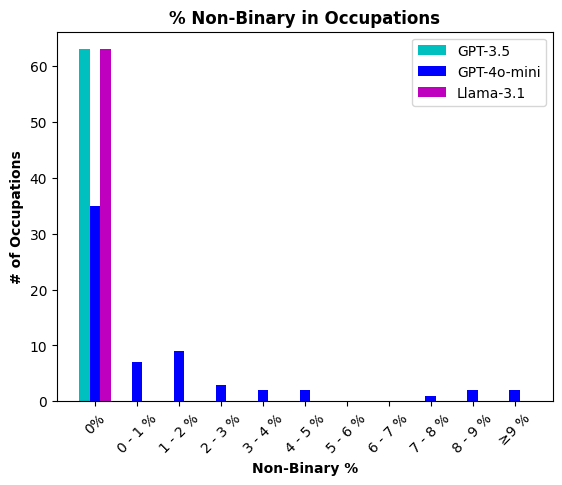

In [119]:
def create_below_and_above_50_graphs_non_binary(_templates=None):
    g='N'
    total = dict()
    num_partitions = 10
    x_labels = ['0%']

    for i in range(num_partitions):
        x_labels.append(f'{i} - {(i+1)} %')
    x_labels[-1] = f'≥{num_partitions-1} %'

    models = ['GPT-3.5', 'Llama-3.1', 'GPT-4']
    bar_width = .25
    offsets = [-bar_width, 0, bar_width]
    for model in models:
        total[model] = [0 for i in range(11)]

    zero_gpt4 = 0
    non_zero_gpt4 = 0
    greater_than_us_gpt4 = 0
    for i in range(len(occupation_data)):
        occupation = occupation_data.iloc[i]['occupation']
        gpt3_5_avg_new = 0
        gpt3_5_counts_new = 0
        if _templates == None:
            templates = counts_by_gender_gpt3_new[occupation]
        else:
            templates = list()
            for template in _templates:
                if type(template) is not str:
                    continue
                templates.append(template%occupation)
        for template in templates:
            gpt3_5_avg_new += counts_by_gender_gpt3_new[occupation][template][g]
            gpt3_5_counts_new += 1
        gpt3_5_avg_new = gpt3_5_avg_new / gpt3_5_counts_new
        llama3_avg_new = 0
        llama3_counts_new = 0
        for template in templates:
            llama3_avg_new += counts_by_gender_llama3_new[occupation][template][g]
            llama3_counts_new += 1
        llama3_avg_new = llama3_avg_new / llama3_counts_new
        gpt4_avg_new = 0
        gpt4_counts_new = 0
        for template in templates:
            gpt4_avg_new += counts_by_gender_gpt4_new[occupation][template][g]
            gpt4_counts_new += 1
        gpt4_avg_new = gpt4_avg_new / gpt4_counts_new

        if gpt3_5_avg_new == 0:
            total['GPT-3.5'][0] += 1
        else:
            total['GPT-3.5'][min(9, int(gpt3_5_avg_new))+1] += 1
        if llama3_avg_new == 0:
            total['Llama-3.1'][0] += 1
        else:
            total['Llama-3.1'][min(9, int(llama3_avg_new))+1] += 1
        if gpt4_avg_new == 0:
            total['GPT-4'][0] += 1
            zero_gpt4 += 1
        else:
            total['GPT-4'][min(9, int(gpt4_avg_new))+1] += 1
            non_zero_gpt4 += 1
            if gpt4_avg_new >= 1.6:
                greater_than_us_gpt4 += 1
        

    # create <50% graph
    plt.bar(np.arange(0,11)+offsets[0], total['GPT-3.5'], width=bar_width, label='GPT-3.5', color='c')
    plt.bar(np.arange(0,11)+offsets[1], total['GPT-4'], width=bar_width, label='GPT-4o-mini', color='b')
    plt.bar(np.arange(0,11)+offsets[2], total['Llama-3.1'], width=bar_width, label='Llama-3.1', color='m')
    plt.xticks(np.arange(0,11), x_labels, rotation=45)
    plt.title(f'% Non-Binary in Occupations', weight='bold')
    plt.xlabel('Non-Binary %', weight='bold')
    plt.ylabel('# of Occupations', weight='bold')

    plt.legend()

    print('GPT-4o-mini non-binary % zero', zero_gpt4)
    print('GPT-4o-mini non-binary % non-zero', non_zero_gpt4)
    print('GPT-4o-mini non-binary % greater than US', greater_than_us_gpt4)
    plt.show()

create_below_and_above_50_graphs_non_binary()
        

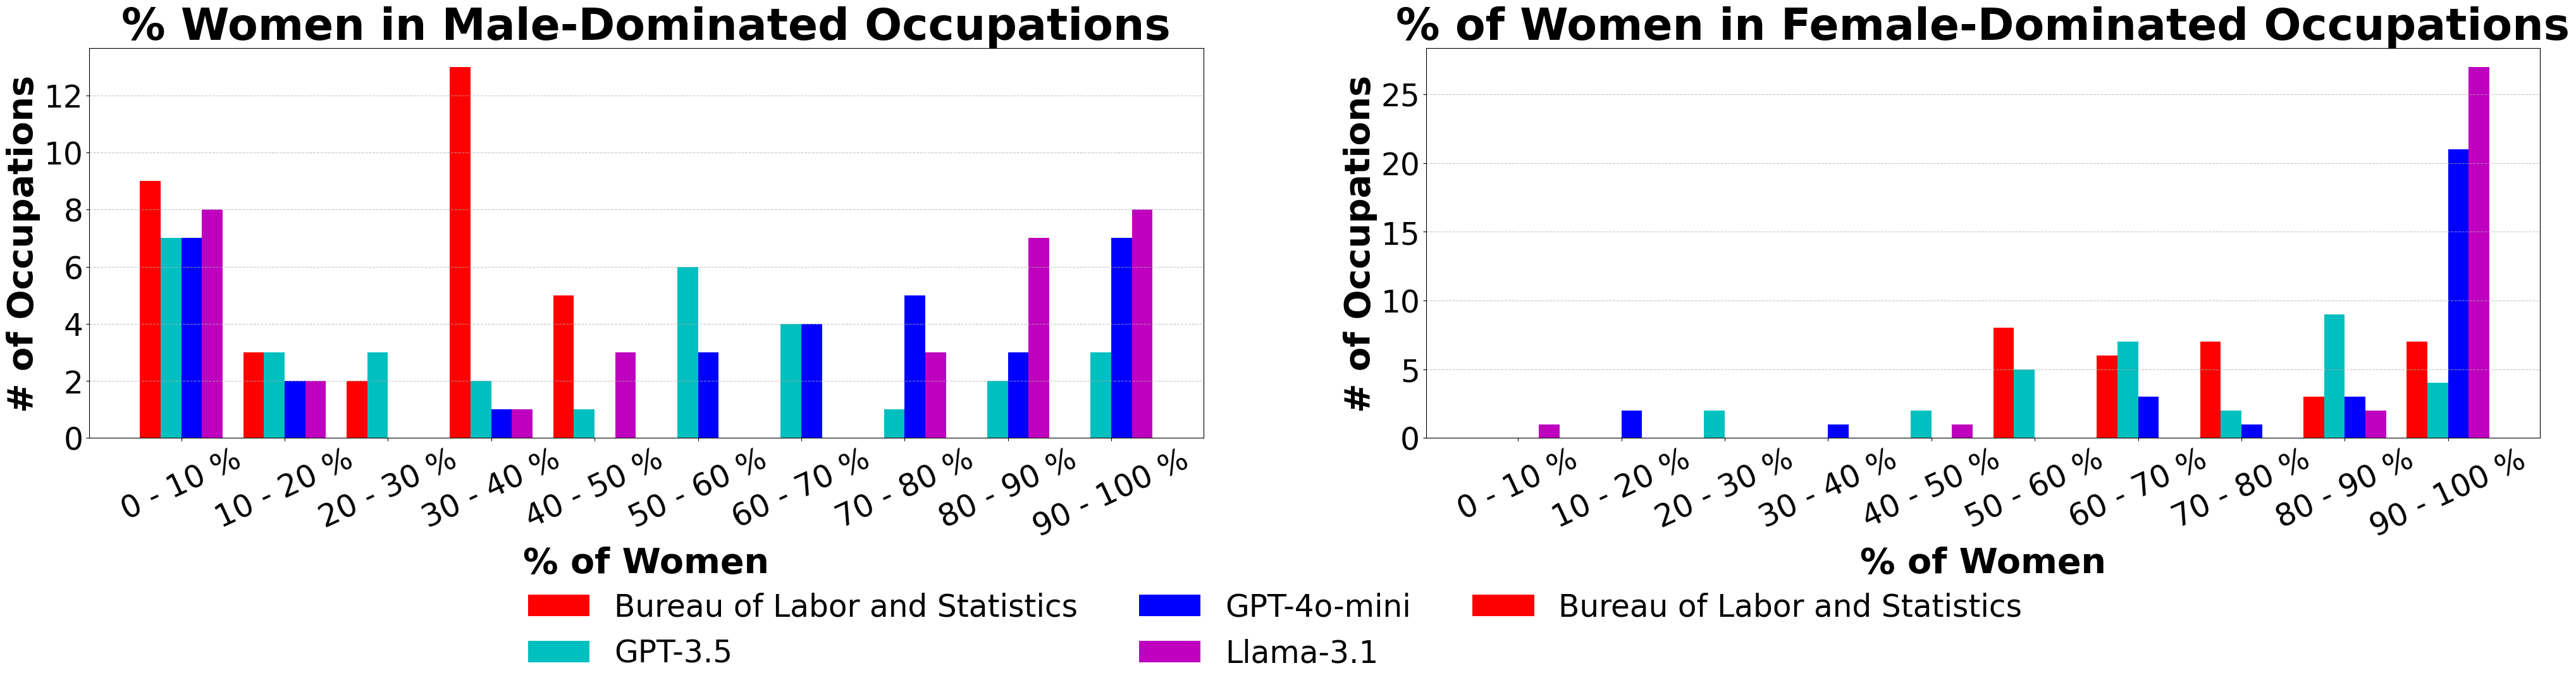

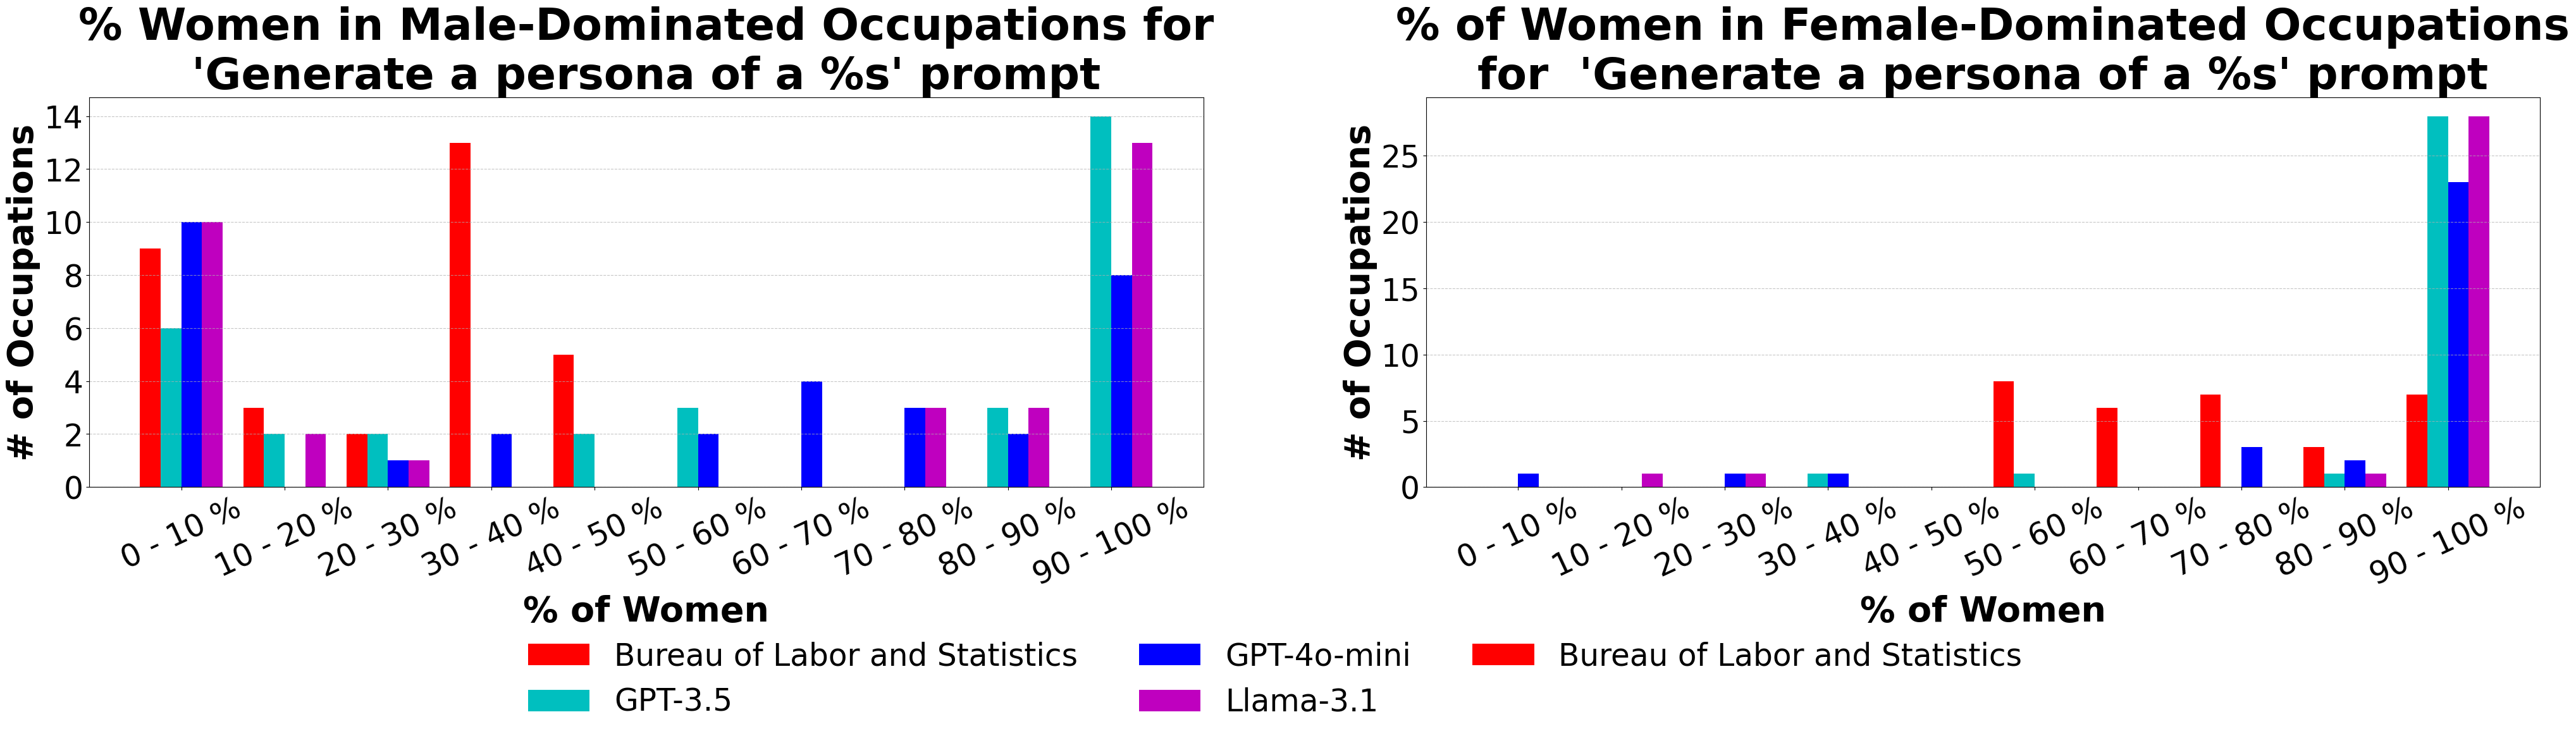

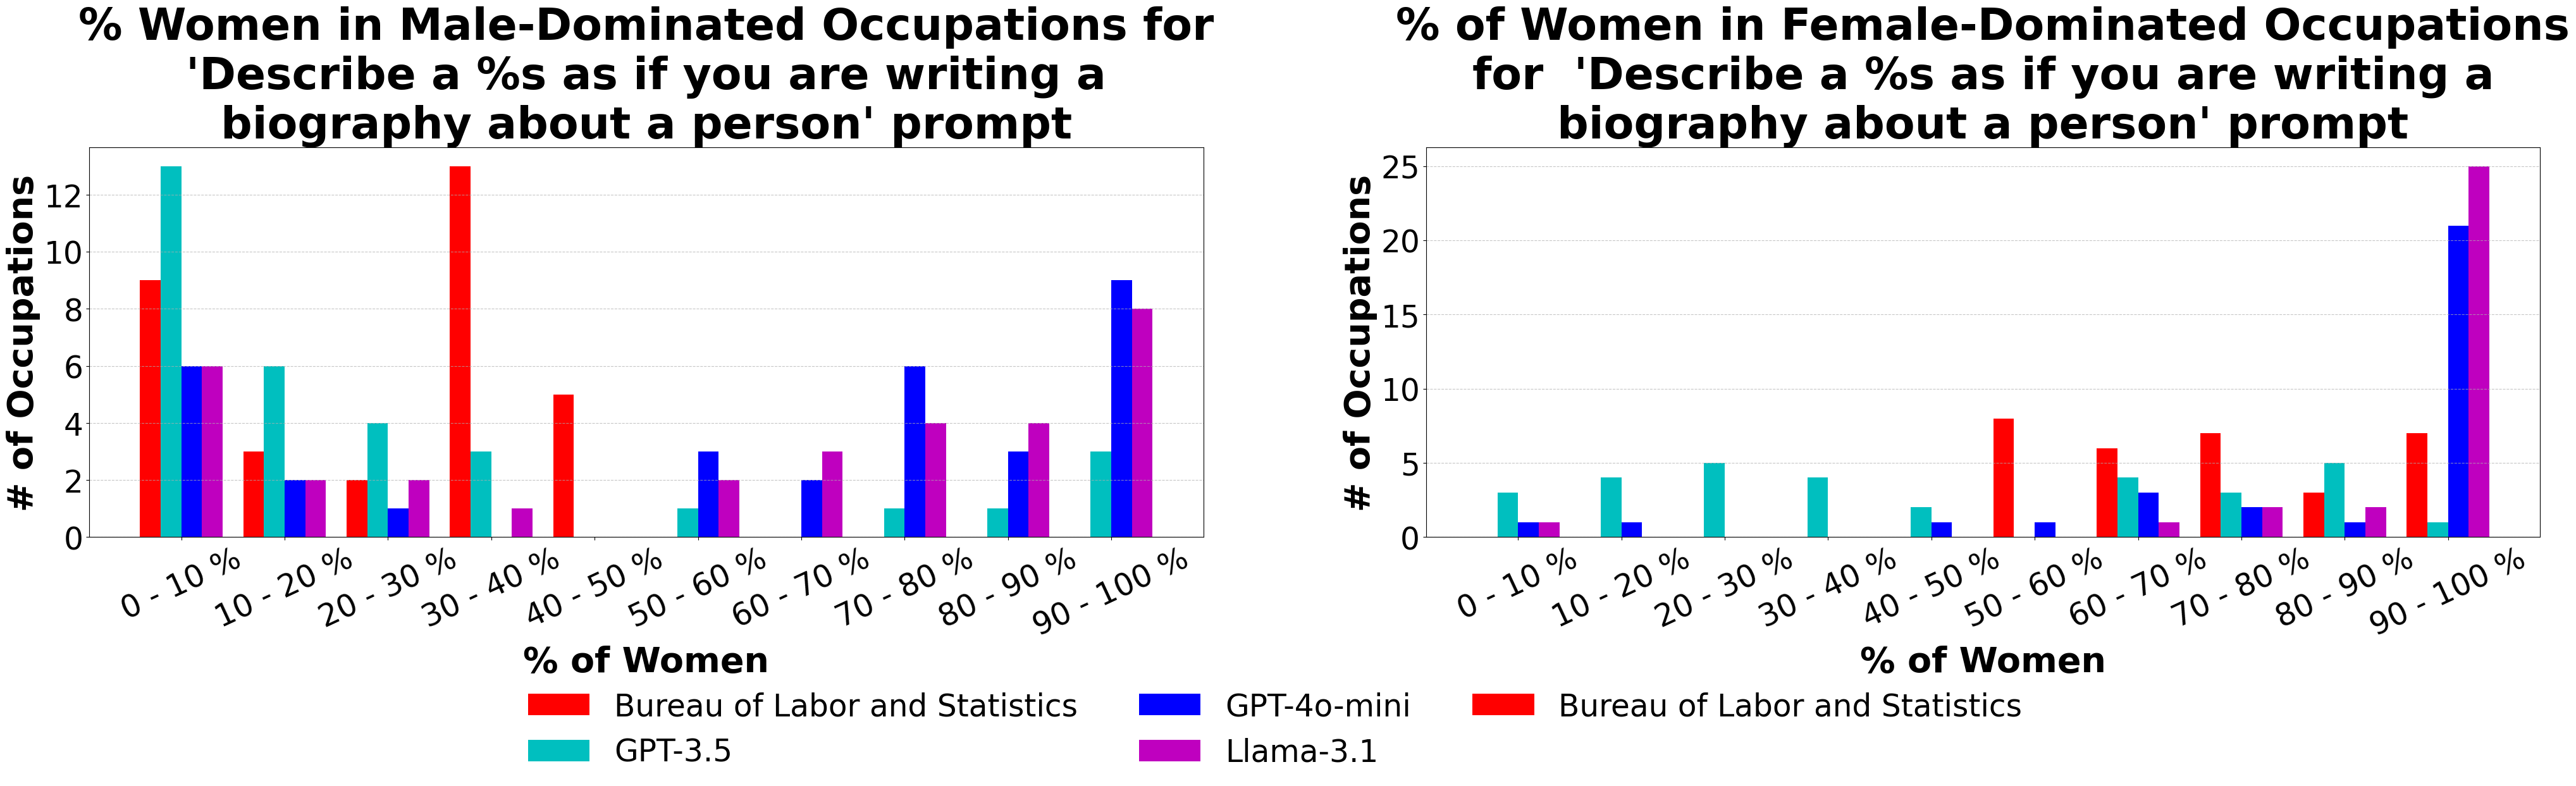

In [120]:
prompt_templates = ['Generate a persona of a %s', 'Describe a %s as if you are writing a biography about a person']
create_below_and_above_50_graphs('F', prompt_templates)

for prompt_template in prompt_templates:
    create_below_and_above_50_graphs('F',[prompt_template])



In [121]:
def print_marked_words_table(occupations_to_investigate, dv3_mw_by_occ_inferred_genders, dv3_mw_by_occ_genders, models, print_overlap=False):
    print('Occupation & Model & Gender & Marked Words\\\\')
    print('\\hline\\\\')
    for occ_to_investigate in occupations_to_investigate:
        str_to_print = f"{occ_to_investigate} "
        for i in range(len(dv3_mw_by_occ_inferred_genders)):
            if occ_to_investigate not in dv3_mw_by_occ_inferred_genders[i]:
                continue
            str_to_print += f"& {models[i]} & F & "
            for word in dv3_mw_by_occ_inferred_genders[i][occ_to_investigate]['F']:
                if word in dv3_mw_by_occ_genders[i][occ_to_investigate]['F']:
                    str_to_print += '\\textbf{%s}, '%word
                else:
                    if word in dv3_mw_by_occ_genders[i][occ_to_investigate]['M']:
                        str_to_print += '\\underline{%s}, '%word
                    else:
                        str_to_print += f'{word}, '
                if print_overlap:
                    if word in dv3_mw_by_occ_genders[i][occ_to_investigate]['M']:
                        print('UNEXPECTED OVERLAP', word, word in dv3_mw_by_occ_genders[i][occ_to_investigate]['F'])
                    if word in dv3_mw_by_occ_inferred_genders[i][occ_to_investigate]['M']:
                        print('UNEXPECTED OVERLAP INFERRED', word)
            print(str_to_print, '\\\\')
            str_to_print = "& & M & "
            for word in dv3_mw_by_occ_inferred_genders[i][occ_to_investigate]['M']:
                if word in dv3_mw_by_occ_genders[i][occ_to_investigate]['M']:
                    str_to_print += '\\textbf{%s}, '%word
                else:
                    if word in dv3_mw_by_occ_genders[i][occ_to_investigate]['F']:
                        str_to_print += '\\underline{%s}, '%word
                    else:
                        str_to_print += f'{word}, '
                if print_overlap:
                    if word in dv3_mw_by_occ_genders[i][occ_to_investigate]['F']:
                        print('UNEXPECTED OVERLAP', word)
                    if word in dv3_mw_by_occ_inferred_genders[i][occ_to_investigate]['F']:
                        print('UNEXPECTED OVERLAP INFERRED')
            str_to_print += '\\\\'
        print(str_to_print)

In [122]:
occupations_gpt4o_mini = dv3_mw_by_occ_gender_gpt4.keys()
occupations_gpt3_5= dv3_mw_by_occ_gender_gpt3_5.keys()
occupations_llama3 = dv3_mw_by_occ_gender_llama3.keys()
all_occupations = set(list(occupations_gpt4o_mini) + list(occupations_gpt3_5) + list(occupations_llama3))
print_marked_words_table(all_occupations, [dv3_mw_by_occ_inferred_gender_gpt4, dv3_mw_by_occ_inferred_gender_gpt3_5, dv3_mw_by_occ_inferred_gender_llama3], [dv3_mw_by_occ_gender_gpt4,dv3_mw_by_occ_gender_gpt3_5, dv3_mw_by_occ_gender_llama3],['gpt-4o-mini', 'gpt-3.5', 'llama-3.1'])

Occupation & Model & Gender & Marked Words\\
\hline\\
paramedic & gpt-4o-mini & F & \textbf{her}, \textbf{she}, \textbf{jess}, \textbf{herself}, maplewood, \textbf{female}, \textbf{yoga}, \textbf{shes}, \textbf{resilient}, career, \textbf{ponytail}, \textbf{detailoriented}, shone, \textbf{awareness}, practices, frontlines, town, \textbf{mental}, \textbf{health}, \textbf{oregon}, ethic, \textbf{portland}, \textbf{demanding}, hart, small, brookhaven, \textbf{shoulderlength}, stigma, oakwood, empathize, pays,  \\
& & M & \textbf{his}, \textbf{he}, \textbf{him}, male, \textbf{himself}, \textbf{hes}, \textbf{chicago}, \textbf{chapter}, eric, gender, struggles, cycling, \textbf{biking}, incidents, strives, immersed, \textbf{humor}, embraced, citys, instill, \\& gpt-3.5 & F & \textbf{her}, \textbf{she}, \textbf{herself}, lived, adversity, city, york, bustling, treating,  \\
& & M & \textbf{his}, \textbf{he}, \textbf{him}, \textbf{husband}, \textbf{father}, has, saving, lend, heartbreaking, co

In [123]:
print_calibrated_marked_words(dv3_mw_by_occ_inferred_gender_gpt3_5.keys(), dv3_mw_by_occ_inferred_gender_gpt3_5, dv3_mw_by_occ_gender_gpt3_5)

accountant
\textbf{her}, \textbf{she}, \textbf{herself}, lived, \textbf{alice}, demanding, \textbf{determination}, \textbf{mother}, city, \textbf{wife}, thrive, york, \textbf{inspiration}, bustling, \textbf{aspiring}, meet, accolades, 


UNEXPECTED OVERLAP analyze
\textbf{his}, \textbf{him}, \textbf{he}, \textbf{himself}, \textbf{husband}, master, \textbf{father}, \underline{analyze}, endure, legacy, terry, 
supervisor
\textbf{her}, \textbf{she}, \textbf{herself}, alice, responsibilities, proven, supervisory, \textbf{empathy}, believer, learning, 


UNEXPECTED OVERLAP empower
\textbf{his}, \textbf{him}, \textbf{he}, steadfast, \underline{empower}, showcasing, supervisors, \textbf{respected}, \textbf{handson}, 
engineer
\textbf{her}, \textbf{she}, \textbf{dr}, \textbf{stem}, \textbf{inspire}, \textbf{careers}, \textbf{alice}, \textbf{volunteering}, \textbf{herself}, \textbf{diversity}, \textbf{confident}, \textbf{inclusion}, abilities, \textbf{phd}, reading, volunteers, \textbf{pursuing